In [3]:
from astropy.io import fits
import astropy.io
import numpy as np
import matplotlib
from astropy.table import Table
import astropy.io
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal
from astroML.stats.random import bivariate_normal
import numpy as np
import pandas as pd
import itertools
plt.interactive(True)

# Loading the Data

Filename: /Users/johnzhang/Desktop/MSDS_MASTERS/Capstone-NRAO/work/test_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     864   (640, 640, 1, 1)   float32   


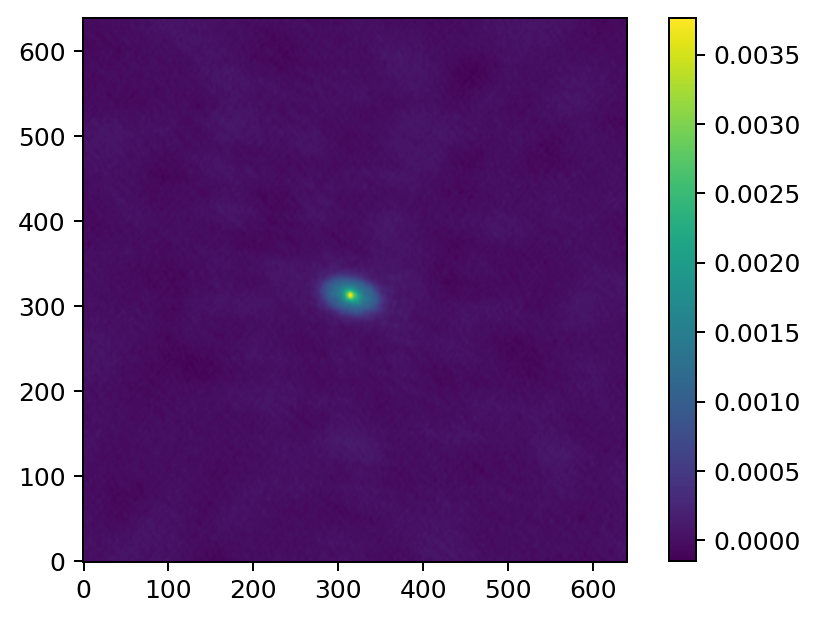

In [31]:
fits1 = fits.open('/Users/johnzhang/Desktop/MSDS_MASTERS/Capstone-NRAO/work/test_4.fits')
fits1.info()
image = fits1[0]

matplotlib.rcParams['figure.dpi'] = 180
plt.imshow(image.data[0,0,:,:], origin='lower')
plt.colorbar()

# Cutting out the Noise

Image shape: (640, 640)
Image min., max.: -0.00015233675 0.0037651635
Image Standard Deviation: 0.00010939385
Image Root-Mean-Square: 0.000109814784


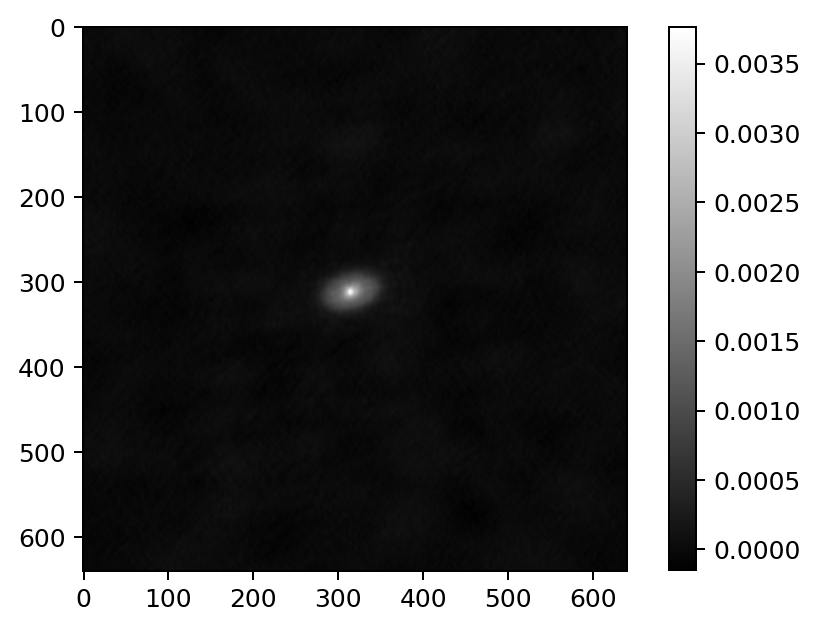

In [4]:
f = fits1
im = f[0]
imdata = im.data.squeeze()
plt.clf()
plt.imshow(imdata,cmap='gray')
plt.colorbar()
print("Image shape:",imdata.shape)
print("Image min., max.:",np.nanmin(imdata), np.nanmax(imdata))
print("Image Standard Deviation:",np.nanstd(imdata))
print("Image Root-Mean-Square:",np.sqrt(np.nanmean(imdata**2)))

## Getting rid of NAN's in image

In [6]:
id1 = np.argwhere(np.isnan(imdata))[:,0]
id2 = np.argwhere(np.isnan(imdata))[:,1]

imdata = np.delete(imdata, id1, axis=0)
imdata = np.delete(imdata, id2, axis=1)

## Jon Ramsey Code Credits:
### Dividing image into 9 chunks to do noise analysis and calculating RMSE for each chunk

In [7]:
#now break the image into chunks and do the same analysis;
# one of the chunks should have no signal in and give you an estimate of the noise (= rms).# number of chunks in each direction:
nchunks = 3 # an odd value is used so that the centre of the image does not correspond to the edge of chunks;
            # when you ask for observations with ALMA, you usually specify that the object of interest be in the
            # center of your image.
size = [i//nchunks for i in imdata.shape]
remain = [i % nchunks for i in imdata.shape]
print("Number of image 'chunks':",nchunks)
print("Guess at size of each chunk + any remainder:",size,remain)# start with uniform/equal chunks
chunks = dict()
k = 0
for j,i in itertools.product(range(nchunks),range(nchunks)):
    chunks[k] = size.copy()
    k += 1# next, account for when the image dimensions are not evenly divisible by `nchunks`.
row_remain, column_remain = 0, 0
for k in chunks:
    if k % nchunks < remain[0]: row_remain = 1
    if k // nchunks < remain[1]: column_remain = 1
    if row_remain > 0:
        chunks[k][0] += 1
        row_remain -= 1
    if column_remain > 0:
        chunks[k][1] += 1
        column_remain -= 1# with that in hand, calculate the lower left corner indices of each chunk
indices = dict()
for k in chunks:
    indices[k] = chunks[k].copy()
    if k % nchunks == 0:
        indices[k][0] = 0
    elif k % nchunks != 0: 
        indices[k][0] = indices[k-1][0] + chunks[k][0]
    if k >= nchunks:
        indices[k][1] = indices[k-nchunks][1] + chunks[k][1]
    else:
        indices[k][1] = 0
    print('Chunk absolute indices:',k,indices[k])# finally, calculate the std. dev. and RMS of each chunk and print to the terminal.
stddev_chunk = dict()
rms_chunk = dict()
for k in chunks:
    i,j = indices[k]
    di,dj = chunks[k]
    x = imdata[i:i+di,j:j+dj]
    stddev_this = np.nanstd(x)
    rms_this = np.sqrt(np.nanmean(x**2))
    stddev_chunk[k] = stddev_this
    rms_chunk[k] = rms_this
    print(k,"Chunk standard deviation:",stddev_this)
    print("  Chunk root mean square:  ",rms_this)

Number of image 'chunks': 3
Guess at size of each chunk + any remainder: [213, 213] [1, 1]
Chunk absolute indices: 0 [0, 0]
Chunk absolute indices: 1 [213, 0]
Chunk absolute indices: 2 [426, 0]
Chunk absolute indices: 3 [0, 213]
Chunk absolute indices: 4 [213, 213]
Chunk absolute indices: 5 [426, 213]
Chunk absolute indices: 6 [0, 426]
Chunk absolute indices: 7 [213, 426]
Chunk absolute indices: 8 [426, 426]
0 Chunk standard deviation: 2.9156674e-05
  Chunk root mean square:   2.996685e-05
1 Chunk standard deviation: 3.5610447e-05
  Chunk root mean square:   3.6774654e-05
2 Chunk standard deviation: 3.74183e-05
  Chunk root mean square:   3.7437036e-05
3 Chunk standard deviation: 3.379939e-05
  Chunk root mean square:   3.4535264e-05
4 Chunk standard deviation: 0.0003009329
  Chunk root mean square:   0.00031508046
5 Chunk standard deviation: 3.4791068e-05
  Chunk root mean square:   3.5274134e-05
6 Chunk standard deviation: 3.04238e-05
  Chunk root mean square:   3.067627e-05
7 Chunk 

In [8]:
immin = np.nanmin(imdata)
immax = np.nanmax(imdata)
# calculate ratio of RMS in each chunk to maximum value in image
ratio = dict()
for k in chunks:
    ratio[k] = rms_chunk[k] / immax
    print(k,"RMS/image max:",ratio[k])
    aratio = np.array([r for r in ratio.values()])
print("Don't choose chunk {:d}!".format(np.where(aratio == aratio.max())[0][0]))



0 RMS/image max: 0.0079589775
1 RMS/image max: 0.009767081
2 RMS/image max: 0.009943004
3 RMS/image max: 0.009172315
4 RMS/image max: 0.08368307
5 RMS/image max: 0.009368553
6 RMS/image max: 0.008147394
7 RMS/image max: 0.009371577
8 RMS/image max: 0.009547023
Don't choose chunk 4!


In [10]:
noise_threshold = (min(rms_chunk.values()))
noise_threshold

2.996685e-05

# Function to fit Bivariate Gaussian with Noise Threshold and plot

In [35]:
def bivariate_fit_plot(X,Y,Z,Noise):
    Z[Z<(Noise)] = 0  # noise in figure
    X, Y = np.meshgrid(X, Y)               #Mesh grid
    pos = np.dstack((X, Y))
    x1_bar = np.average(X, weights=Z)      #Weighted X
    x2_bar = np.average(Y, weights=Z)      #Weighted Y
    x1_var = np.average((X-x1_bar)**2, weights=Z)  #Weighted X variance
    x2_var = np.average((Y-x2_bar)**2, weights=Z)  #Weighted Y variance
    x_cov = np.average(X*Y, weights=Z)-x1_bar*x2_bar #Covariance 

    cov_mat = np.array([[x1_var, x_cov],[x_cov, x2_var]]) #Covariance matrix
    rv = stats.multivariate_normal([x1_bar, x2_bar], cov_mat) #Fitting a new Gaussian Normal with our parameters.
    
    
    Residual = rv.pdf(pos)
    Residual[Residual< (3*Noise)] = 0
    s1 = (rv.pdf(pos)-Z)**2 
    s1.ravel().sum() / np.max(Z)
    plt.contour(X, Y, rv.pdf(pos),3, colors = 'white', linewidths = 1) #Plot
    Z.nonzero()[0].shape
    plt.imshow(image.data[0,0,:,:], origin='lower') 
    plt.colorbar()
    print("Your SSE of Residuals is" ,s1.ravel().sum() / np.max(Z))

In [38]:
X = range(len(image.data[0,0,:,:][0]))
Y = range(len(image.data[0,0,:,:]))
Z = image.data[0,0,:,:]               
Z = np.nan_to_num(Z,  0) 

Your SSE of Residuals is 1.059882653097071


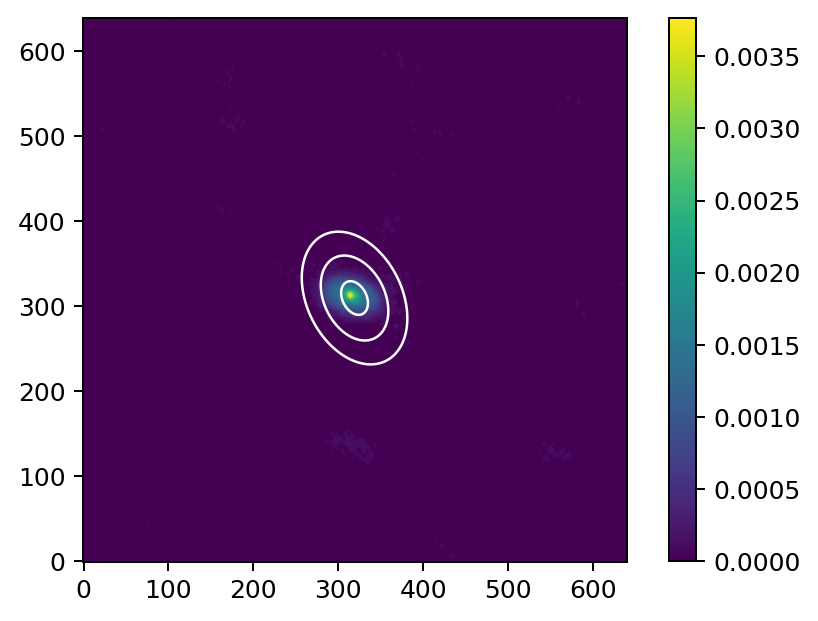

In [39]:
bivariate_fit_plot(X,Y,Z,Noise = (3 * noise_threshold))